In [98]:
from data_preprocessing import *
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, to_rgb
import torch
import torch.nn as nn

import networkx as nx
import community
from scipy.stats import ttest_ind

from sklearn.manifold import MDS
import scipy.cluster.hierarchy as sch
from sklearn import preprocessing
import nimfa

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import minmax_scale

# Source: https://www.nature.com/articles/s42003-022-04186-y
from gene_interaction_models import Encoder, Predictor, SparseNN, NNtraining, GlobalSIS

# ignore FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# plotting settings
sns.set_style("ticks", rc={"font.size": 11})
plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.size": 11})

In [32]:
# optical helper for plotting
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
trunc_cmap = truncate_colormap(plt.get_cmap('BrBG'), 0.65, 0.9)

In [34]:
# optical helper for plotting
def clean_axis(ax, spine=False):
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    if not spine:
        for sp in ax.spines.values():
            sp.set_visible(False)

# 3. Understanding Patterns

### 3.1 Community search in a correlation network

In [5]:
# read in data, filtered to super contigs
SIGNIFICANCE_LEVEL = 1e-04  # fewer contigs: 1e-05; more contigs: 1e-03

# use only the contigs that show significant differences between high and low methane output (sign level 1e-04)
df = pd.read_csv('Results/Contigs_with_classwise_t-tests_and_distributions.csv')
df = df[df['p-value'] <= SIGNIFICANCE_LEVEL]

df = df_cpm[df['Contig']]
df.columns.name = None

In [6]:
# find statistically significant interactions
sign_matrix = pd.DataFrame(columns=['Contig1', 'Contig2', 'p-value'])

for i,c1 in enumerate(df.columns):
    for c2 in df.columns[i+1:]:
        t_stat, p_value = ttest_ind(df[c1], df[c2])
        appme = pd.DataFrame([[c1, c2, p_value]], columns=sign_matrix.columns)
        sign_matrix = pd.concat([sign_matrix, appme], ignore_index=True)

In [7]:
# significance threshold
T = 0.9 # at least 90% confidence that counts for a contig from two samples stem from the same distribution
sign_matrix_filtered = sign_matrix[sign_matrix['p-value'] > T]

In [8]:
# convert to graph
G = nx.Graph()

for _, row in sign_matrix_filtered.iterrows():
    G.add_edge(row['Contig1'], row['Contig2'], weight=row['p-value'])

In [9]:
# Detect communities using the Louvain method
communities = community.best_partition(G)

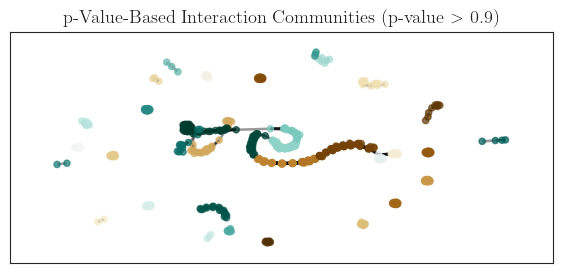

In [11]:
# plot
plt.figure(figsize=(7, 3))

pos = nx.spring_layout(G)  # Choose layout algorithm
edges = G.edges(data=True)
nx.draw_networkx_nodes(G, pos, alpha=0.7, node_size=20, 
                       node_color=list(communities.values()), cmap=plt.colormaps.get_cmap('BrBG'))
nx.draw_networkx_edges(G, pos, alpha=0.4, edgelist=edges, width=[d['weight']*2 for (u, v, d) in edges])
# nx.draw_networkx_labels(G, pos, font_size=6, font_family='serif')

plt.title(f'p-Value-Based Interaction Communities (p-value $>$ {T})')
plt.show()

### 3.2 Matrix Factorization

In [13]:
SIGNIFICANCE_LEVEL = 1e-05

# use only supercontigs
df = pd.read_csv('Results/Contigs_with_classwise_t-tests_and_distributions.csv')
df = df[df['p-value'] <= SIGNIFICANCE_LEVEL]

In [14]:
# split into high/low samples
data = df_cpm[df['Contig']].to_numpy()  # sheep x contigs
methane_level = df_cpm.join(df_clusters)['Cluster'].to_list()
datah = data[np.array(methane_level) == 'high', :]
datal = data[np.array(methane_level) == 'low', :]
samplelabelsh = df_cpm.index[np.array(methane_level) == 'high']
samplelabelsl = df_cpm.index[np.array(methane_level) == 'low']

In [15]:
# dictionary to map index positions to contig labels
contig2id = {c: idx for idx, c in enumerate(df['Contig'].to_list())}
id2contig = dict(zip(contig2id.values(), contig2id.keys()))

In [16]:
# Each sample (sheep) is rescaled independently of other samples so that its l2 norm equals one.
data = preprocessing.Normalizer().fit_transform(data)
datah = preprocessing.Normalizer().fit_transform(datah)
datal = preprocessing.Normalizer().fit_transform(datal)

#### Determine ranks (l)

In [21]:
rank_cands = range(2, 11, 1)

# high sheep
snmf = nimfa.Snmf(datah, seed='random_vcol', max_iter=50)
summaryh = snmf.estimate_rank(rank_range=rank_cands, n_run=10, what='all')

# low sheep
snmf = nimfa.Snmf(datal, seed='random_vcol', max_iter=50)
summaryl = snmf.estimate_rank(rank_range=rank_cands, n_run=10, what='all')

#### plot statistics for different ranks

In [43]:
def plot_rank_summary(summary, rank_cands):
    rss = [summary[rank]['rss'] for rank in rank_cands]
    coph = [summary[rank]['cophenetic'] for rank in rank_cands]
    disp = [summary[rank]['dispersion'] for rank in rank_cands]
    spar = [summary[rank]['sparseness'] for rank in rank_cands]
    spar_w, spar_h = zip(*spar)
    evar = [summary[rank]['evar'] for rank in rank_cands]

    plt.figure(figsize=(3, 2))
    plt.plot(rank_cands, rss, 'o-', label='RSS', linewidth=2)
    plt.plot(rank_cands, coph, 'o-', label='Cophenetic correlation', linewidth=2)
    plt.plot(rank_cands, disp,'o-', label='Dispersion', linewidth=2)
    plt.plot(rank_cands, spar_w, 'o-', label='Sparsity (Basis)', linewidth=2)
    plt.plot(rank_cands, spar_h, 'o-', label='Sparsity (Mixture)', linewidth=2)
    plt.plot(rank_cands, evar, 'o-', label='Explained variance', linewidth=2)
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), ncol=1, numpoints=1, frameon=False);

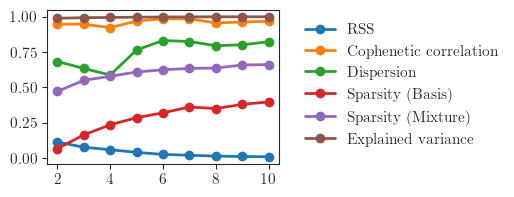

In [44]:
plot_rank_summary(summaryh, rank_cands)

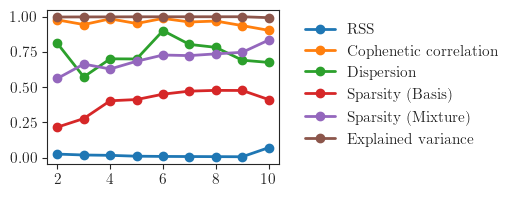

In [45]:
plot_rank_summary(summaryl, rank_cands)

#### Final matrix factorizations for rank = 7

In [25]:
rank = 7
snmfh = nimfa.Snmf(datah.T, rank=rank, seed='random_vcol', version='l', max_iter=200)
snmf_fith = snmfh()

snmfl = nimfa.Snmf(datal.T, rank=rank, seed='random_vcol', version='l', max_iter=200)
snmf_fitl = snmfl()

Wh = snmf_fith.fit.basis()
Wl = snmf_fitl.fit.basis()

#### Multi-dimensional scaling (MDS)

In [26]:
# prepare data
df_tmp = df_cpm[df['Contig']]
contiglist = df_tmp.columns
df_tmp = df_tmp.corr('pearson').abs()

# train embedding
embedding = MDS(n_components=2, dissimilarity='precomputed', normalized_stress='auto')
X_trf = embedding.fit_transform(1 - df_tmp.to_numpy())

In [28]:
# sparsify the matrices for plotting
Wh = np.array(Wh.tolist())
Wl = np.array(Wl.tolist())
Wh[Wh <= 1e-01] = 0
Wl[Wl <= 1e-01] = 0

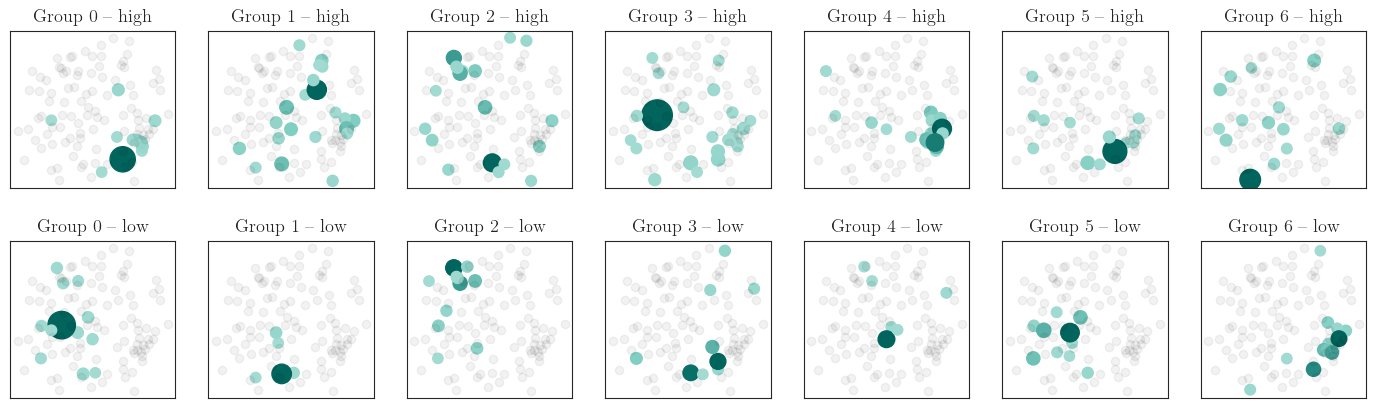

In [35]:
# plot
fig, ax = plt.subplots(2,rank, figsize=(2.5*rank,5))
for group in range(rank):
    member = Wh[:,group] > 0
    ax[0,group].scatter(X_trf[member,0], X_trf[member,1], c=Wh[member,group], cmap=trunc_cmap, s=50+Wh[member,group]*50)
    ax[0,group].scatter(X_trf[~member,0], X_trf[~member,1], c='black', alpha=0.05)
    ax[0,group].set_aspect('equal', adjustable='box')
    clean_axis(ax[0,group], spine=True)
    ax[0,group].set_title('Group '+str(group)+' -- high')
    
    member = Wl[:,group] > 0
    ax[1,group].scatter(X_trf[member,0], X_trf[member,1], c=Wl[member,group], cmap=trunc_cmap, s=50+Wl[member,group]*50)
    ax[1,group].scatter(X_trf[~member,0], X_trf[~member,1], c='black', alpha=0.05)
    ax[1,group].set_aspect('equal', adjustable='box')
    clean_axis(ax[1,group], spine=True)
    ax[1,group].set_title('Group '+str(group)+' -- low')
        
plt.show()

In [36]:
# obtaining group-to-contig mappings
# tmp = np.empty((0,4))
# for i in range(rank):
#     tmp = np.concatenate((tmp, np.column_stack((contiglist, ['high']*len(contiglist), [i]*len(contiglist), Wh[:,i]))))
#     tmp = np.concatenate((tmp, np.column_stack((contiglist, ['low']*len(contiglist), [i]*len(contiglist), Wl[:,i]))))
# df_groups = pd.DataFrame(tmp, columns=['Contig', 'Methane Output Level', 'Group Number', 'Membership Score'])
# df_groups = df_groups[df_groups['Membership Score'] > 0]
# df_groups.to_csv('Results/Contig_Groups_NMF.csv', header=True, index=False)

### 3.3 Neural Networks with Shapley Taylor Interaction Index

The analysis is using the source code from the article:

https://www.nature.com/articles/s42003-022-04186-y

GitHub repo: https://github.com/tycui/GWAS_NN/tree/main

#### Prepare Data

In [94]:
# Hyper-parameters
SIGNIFICANCE_LEVEL = 1e-04  # fewer contigs: 1e-05; more contigs: 1e-03
number_of_groups = 10
reg_weight_encoder = 0.001
reg_weight_predictor = 0.001

learning_rate = 0.001
num_epoch = 30

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [95]:
## load data

# use only the contigs that show significant differences between high and low methane output (sign level 1e-04)
df = pd.read_csv('Results/Contigs_with_classwise_t-tests_and_distributions.csv')
df = df[df['p-value'] <= SIGNIFICANCE_LEVEL]
sample_to_fold = {1111: 0, 1174: 1, 1234: 2, 1265: 3, 1283: 4, 1333: 5, 1363: 6, 1435: 7, 1494: 8, 1586: 9}

# df_gene:  columns = contigs (methane output in last columns)
df_sheep_ids = sheep_grouped[['Metatranscriptome ID', 'Sheep#']].set_index('Metatranscriptome ID')
df_gene = df_cpm[df['Contig']].join(df_sheep_ids, how='inner')
df_gene['fold'] = df_gene['Sheep#'].map(sample_to_fold)
df_gene = df_gene.drop('Sheep#', axis=1)

In [96]:
df_gene_transposed = df_gene.T
y = torch.tensor(df_gene_transposed.iloc[-2].values)
y = y.reshape(y.shape[0], 1) # methane output is y
fold = df_gene_transposed.iloc[-1].values
df_X = df_gene.iloc[:, :-2]

### 3.3 (a) Group interactions

#### Set up and train network

In [62]:
train_MSEs = []
test_MSEs = []
scaler = MinMaxScaler(feature_range = (0, 1))

for f in range(int(max(fold))):
    tr, te = fold!=f, fold==f
    X_train, X_test, y_train, y_test = df_X.to_numpy()[tr], df_X.to_numpy()[te], y[tr], y[te]
    
    X_train = torch.from_numpy(scaler.fit_transform(X_train))
    X_test = torch.from_numpy(scaler.transform(X_test))
    
    y_train = torch.from_numpy(scaler.fit_transform(y_train))
    y_test = torch.from_numpy(scaler.transform(y_test))

    ## Gene interaction NN training
    input_dim = len(X_train[0])
    encoder = Encoder(input_dim, number_of_groups, device = device)
    predictor = Predictor(number_of_groups)
    ginn = SparseNN(encoder, predictor)
    GINN = NNtraining(ginn, 
                    learning_rate=learning_rate, 
                    batch_size=1, 
                    num_epoch=int(num_epoch), 
                    reg_weight_encoder=reg_weight_encoder, 
                    reg_weight_predictor=reg_weight_predictor,
                    use_cuda = False,
                    use_early_stopping = False)
    l, lv = GINN.training(X_train, y_train, X_test, y_test)
    
    train_MSEs.append(l)
    test_MSEs.append(lv)

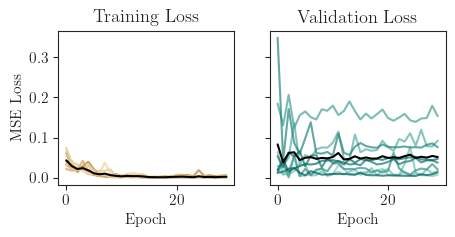

In [63]:
# plot training/validation loss
fig, ax = plt.subplots(1,2, figsize=(5, 2), sharey=True)
for i in range(len(train_MSEs)):
    ax[0].plot(train_MSEs[i], c=sns.color_palette("BrBG", 36).as_hex()[5+i], alpha=0.7)
    ax[1].plot(test_MSEs[i], c=sns.color_palette("BrBG", 36).as_hex()[25+i], alpha=0.7)
ax[0].set_title('Training Loss')
ax[1].set_title('Validation Loss')
ax[0].set_ylabel('MSE Loss')
ax[0].plot(np.average(train_MSEs, axis=0), c='black')
ax[1].plot(np.average(test_MSEs, axis=0), c='black')
for i in range(2):
    ax[i].set_xlabel('Epoch')

plt.show()

#### Re-train on all samples

In [88]:
scaler = MinMaxScaler(feature_range = (0, 1))
X_all = torch.from_numpy(scaler.fit_transform(df_X)).double()
y_all = torch.from_numpy(scaler.fit_transform(y)).double()

input_dim = len(X_test[0])
encoder = Encoder(input_dim, number_of_groups, device = device)
predictor = Predictor(number_of_groups)
ginn = SparseNN(encoder, predictor)
GINN = NNtraining(ginn, 
                learning_rate=learning_rate, 
                batch_size=1, 
                num_epoch=int(num_epoch), 
                reg_weight_encoder=reg_weight_encoder, 
                reg_weight_predictor=reg_weight_predictor,
                use_cuda = False,
                use_early_stopping = True)
l, lv = GINN.training(X_all, y_all, X_all, y_all)

#### Shapley Taylor Interaction Index

In [89]:
# Access formed groups
# 2D weight array: input x groups
weights = GINN.model.encoder.layer.w.detach().numpy()

In [90]:
## Interaction detection
num_samples = 5; 
prediction_test, _, _ = GINN.model(X_all)
prediction_test.detach_()
value_high, idx_high = torch.topk(prediction_test.reshape(-1), int(num_samples/2))
value_low, idx_low = torch.topk(prediction_test.reshape(-1), int(num_samples/2), largest=False)
idx = torch.concat([idx_low, idx_high])
gene_test, _ = GINN.model.encoder(X_all[idx]); 
gene_test.detach_()
baseline = torch.mean(gene_test, dim = 0).view(1,-1)
GlobalSIS_NN, topGlobalSIS_NN, Shapely_NN = GlobalSIS(GINN.model.predictor, gene_test, baseline)

In [91]:
# extract interaction scores
group_pairs = np.array([key.split(' ') for key in list(GlobalSIS_NN.keys())])[:, [1,2]].astype(int)
interaction_scores = np.array(list(GlobalSIS_NN.values()))
# scale interaction scores to [0,1]
interaction_scores = minmax_scale(interaction_scores)

G = nx.Graph()
for i in range(len(interaction_scores)):
    G.add_edge(group_pairs[i][0], group_pairs[i][1], weight=interaction_scores[i])

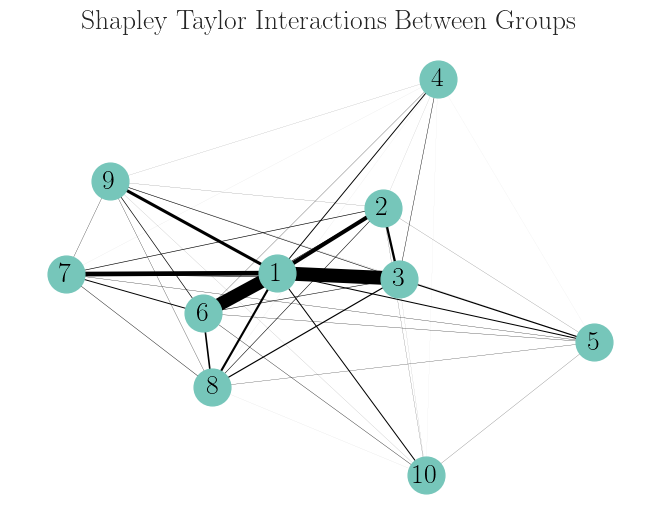

In [92]:
# plot
pos = nx.spring_layout(G, seed=2210)

edges = G.edges()
weights = [G[u][v]['weight']*10 for u,v in edges]

nx.draw(G, pos, edge_color='black', width=weights, node_size=700, node_color=sns.color_palette("BrBG", 6).as_hex()[4])
nx.draw_networkx_labels(G, pos, font_size=20, font_family="serif")

plt.title('Shapley Taylor Interactions Between Groups', fontsize=20)
plt.show()

### 3.3 (b) Contig interactions

#### Set up NN

In [99]:
class Net(nn.Module):

    def __init__(self, input_dim, hidden_dim1, hidden_dim2=100, output_dim=1):
        super(Net, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim1)
        self.layer2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.layer3 = nn.Linear(hidden_dim2, output_dim)
        self.activation_fn = nn.Softplus(beta = 10)

    def forward(self, x):
        x = self.layer1(x)
        x = self.activation_fn(self.layer2(x))
        x = self.layer3(x)
        return x

In [103]:
device = torch.device('cpu')
criteria = nn.MSELoss(reduction = "mean")
model = Net(len(X_test[0]), 100)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [104]:
def train_model(model, X_train, y_train, X_test, y_test, epochs_num):

    model.train()
    losses = []
    validation_losses = []
    for epoch in range(epochs_num):
        model.train()
        optimizer.zero_grad()
        out = model(X_train.to(device))
        loss = criteria(out, y_train.float().to(device))
        validation_loss = criteria(model(X_test.to(device)), y_test.float().to(device))
        losses.append(loss.item())
        validation_losses.append(validation_loss.item())
        
        loss.backward()
        optimizer.step()
    return losses, validation_losses

#### Find hyperparameters

In [105]:
train_MSEs = []
test_MSEs = []
scaler = MinMaxScaler(feature_range = (0, 1))

# for tr, te in kfold.split(df_X, y):
for f in range(int(max(fold))):
    tr, te = fold!=f, fold==f
    X_train, X_test, y_train, y_test = df_X.to_numpy()[tr], df_X.to_numpy()[te], y[tr], y[te]
    
    X_train = torch.from_numpy(scaler.fit_transform(X_train)).float()
    X_test = torch.from_numpy(scaler.transform(X_test)).float()
    
    y_train = torch.from_numpy(scaler.fit_transform(y_train))
    y_test = torch.from_numpy(scaler.transform(y_test))

    model = Net(len(X_test[0]), 10, hidden_dim2=10)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    l, lv = train_model(model, X_train, y_train, X_test, y_test, 20)
    train_MSEs.append(l)
    test_MSEs.append(lv)

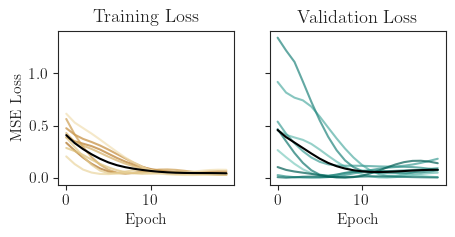

In [106]:
# plot
fig, ax = plt.subplots(1,2, figsize=(5, 2), sharey=True)
for i in range(len(train_MSEs)):
    ax[0].plot(train_MSEs[i], c=sns.color_palette("BrBG", 36).as_hex()[5+i], alpha=0.7)
    ax[1].plot(test_MSEs[i], c=sns.color_palette("BrBG", 36).as_hex()[25+i], alpha=0.7)
ax[0].set_title('Training Loss')
ax[1].set_title('Validation Loss')
ax[0].set_ylabel('MSE Loss')
ax[0].plot(np.average(train_MSEs, axis=0), c='black')
ax[1].plot(np.average(test_MSEs, axis=0), c='black')
for i in range(2):
    ax[i].set_xlabel('Epoch')

plt.show()

#### Find interactions

In [107]:
def GlobalSIS(predictor, X, baseline, num_permutation = 10):
    num_individual, num_gene = X.shape
    Shapely = np.zeros([num_gene, num_gene])    
    for i in range(num_individual):
        print('Processing individual', i, '/', num_individual)
        x = X[i].clone()
        Shapely = Shapely + abs(ShapleyIS(predictor, x, baseline.view(-1), num_permutation))
    Shapely = Shapely / num_individual
    GlobalSIS, topGlobalSIS = matric2dic(Shapely, 10)
    return GlobalSIS, topGlobalSIS, Shapely 

def ShapleyIS(predictor, xi, baseline, num_permutation):
    num_gene = xi.shape[0]
    SHAPLEYIS = np.zeros([num_gene, num_gene])
    for m in range(num_permutation):
        print('\tProcessing permutation', m, '/', num_permutation)
        perm = list(np.random.permutation(num_gene)); T = []
        shapleyis = np.zeros([num_gene, num_gene])
        for i in range(len(perm)):
            if i >= 1:
                T.append(perm[i-1])
            for j in range(i+1, len(perm)):
                shapleyis[perm[i]][perm[j]] = deltaF(predictor, xi, baseline, [perm[i],perm[j]], T)
        SHAPLEYIS = SHAPLEYIS + shapleyis

    SHAPLEYIS = (SHAPLEYIS + SHAPLEYIS.T) / num_permutation
    SHAPLEYIS = SHAPLEYIS +  np.diag(ShapleyValue(predictor, xi, baseline)) 
    return SHAPLEYIS

def copy_values(xi, baseline, index_set):
    tij = baseline.clone()
    for i in index_set:
        tij[i] = xi[i]
    return tij
    
def deltaF(predictor, xi, baseline, interaction, T):
    Tij = copy_values(xi, baseline, T + interaction).view(1,-1)
    Ti = copy_values(xi, baseline, T + [interaction[0]]).view(1,-1)
    Tj = copy_values(xi, baseline, T + [interaction[1]]).view(1,-1)
    T = copy_values(xi, baseline, T).view(1,-1)
    output_Tij = predictor(Tij); output_Ti = predictor(Ti); output_Tj = predictor(Tj); output_T = predictor(T); 
    return output_Tij.item() - output_Ti.item() - output_Tj.item() + output_T.item()

def ShapleyValue(predictor, xi, baseline):
    num_gene = xi.shape[0]
    shapleyvalue = np.zeros([num_gene])
    for i in range(num_gene):
        shapleyvalue[i] = delta_main(predictor, xi, baseline, [i])
    return shapleyvalue

def delta_main(predictor, xi, baseline, main_index):
    Ti = copy_values(xi, baseline, main_index).view(1,-1)
    T = copy_values(xi, baseline, []).view(1,-1)
    output_Ti = predictor(Ti); output_T = predictor(T); 
    return output_Ti.item() - output_T.item()

def matric2dic(hessian, K):
    IS = {}
    for i in range(len(hessian[0])):
        for j in range(i+1, len(hessian[0])):
            tmp = 0
            interation = 'Interaction: '
            interation = interation + str(i + 1) + ' ' + str(j + 1) + ' '
            IS[interation] = hessian[i][j]
    Sorted_IS = [(k, IS[k]) for k in sorted(IS, key=IS.get, reverse=True)]
    return IS, Sorted_IS

In [109]:
X_all = torch.from_numpy(scaler.fit_transform(df_X)).float()
y_all = torch.from_numpy(scaler.fit_transform(y)).float()

In [120]:
# num_samples = 2
# prediction_test = model(X_all).detach_()
# value_high, idx_high = torch.topk(prediction_test.reshape(-1), int(num_samples/2))
# value_low, idx_low = torch.topk(prediction_test.reshape(-1), int(num_samples/2), largest=False)
# idx = torch.concat([idx_low, idx_high])
# gene_test = X_all[idx]
# baseline = torch.mean(gene_test, dim = 0).view(1,-1)

# GlobalSIS_NN, topGlobalSIS_NN, Shapely_NN = GlobalSIS(model, gene_test, baseline)

In [119]:
# np.savetxt('Results/Supercontigs_InteractionScores_ShapleyNN.csv', Shapely_NN, delimiter=",")
# with open('Results/Supercontigs_InteractionScores_GlobalSISNN.csv', 'w') as f:
#     print(GlobalSIS_NN, file=f)

In [113]:
import ast 
  
# reading the data from the file 
file = 'Results/Supercontigs_InteractionScores_GlobalSISNN.csv'
with open(file) as f: 
    data = f.read() 

# reconstructing the data as a dictionary 
GlobalSIS_NN = ast.literal_eval(data) 

In [121]:
group_pairs = np.array([key.split(' ') for key in list(GlobalSIS_NN.keys())])[:, [1,2]].astype(int)
interaction_scores = np.array(list(GlobalSIS_NN.values()))
# scale interaction scores to [0,1]
interaction_scores = minmax_scale(interaction_scores)

#### Visualizing strongest interactions

In [131]:
# filter and transform interaction scores to graph
WEIGHT_THRESHOLD = 0.5
G = nx.Graph()
for i in range(len(interaction_scores)):
    if interaction_scores[i] > WEIGHT_THRESHOLD:
        G.add_edge(np.array(df_X.columns)[group_pairs[i][0]-1], 
                   np.array(df_X.columns)[group_pairs[i][1]-1], 
                   weight=interaction_scores[i])

In [132]:
# remove all nodes that are isolated to make the graph more readable
G.remove_nodes_from(list(nx.isolates(G)))
len(G.nodes())

75

In [133]:
# prepare plot
pos = nx.kamada_kawai_layout(G)
labels = {node: node for node in G.nodes}
edges = G.edges()
weights = [G[u][v]['weight']*3 for u,v in edges]

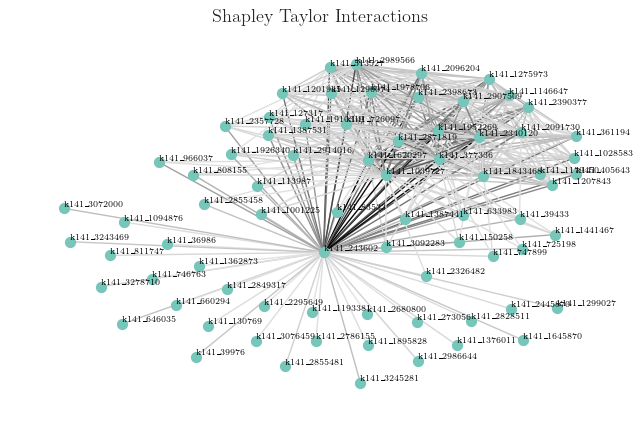

In [134]:
# plot
fig, ax = plt.subplots(1, figsize=(8, 5))
nx.draw(G, pos, edge_color=weights, width=1, node_size=50, 
        node_color=sns.color_palette("BrBG", 6).as_hex()[4],
        with_labels=False, edge_cmap=truncate_colormap(plt.cm.Greys, 0.2, 1))
nx.draw_networkx_labels(G, pos, labels, verticalalignment="bottom", 
                        horizontalalignment='left', font_size=6,
                        clip_on=False)

plt.title('Shapley Taylor Interactions')
plt.savefig("Plots/Supercontigs_Interactions_threshold"+str(WEIGHT_THRESHOLD)+".pdf", bbox_inches='tight')
plt.show()

#### Visualizing communities of interactions (non-annotated)

In [175]:
# filter and transform interaction scores to graph
WEIGHT_THRESHOLD = 0.5
G = nx.Graph()
for i in range(len(interaction_scores)):
    if interaction_scores[i] > WEIGHT_THRESHOLD:
        G.add_edge(np.array(df_X.columns)[group_pairs[i][0]-1], 
                   np.array(df_X.columns)[group_pairs[i][1]-1], 
                   weight=interaction_scores[i])

In [176]:
# Detect communities using the Louvain method
communities = community.best_partition(G)

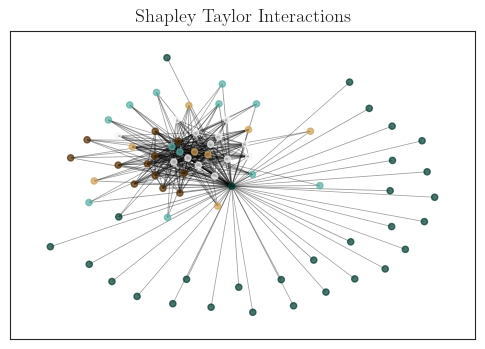

In [192]:
# plot
plt.figure(figsize=(6, 4))

pos = nx.spring_layout(G)  # Choose layout algorithm
edges = G.edges(data=True)
nx.draw_networkx_nodes(G, pos, alpha=0.7, node_size=20, 
                       node_color=list(communities.values()), cmap=plt.colormaps.get_cmap('BrBG'))
nx.draw_networkx_edges(G, pos, alpha=0.4, edgelist=edges, width=[d['weight'] for (u, v, d) in edges])
# nx.draw_networkx_labels(G, pos, font_size=6, font_family='serif')

plt.title('Shapley Taylor Interactions')
plt.savefig("Plots/Supercontigs_Interactions_threshold_noannot.pdf", bbox_inches='tight')
plt.show()

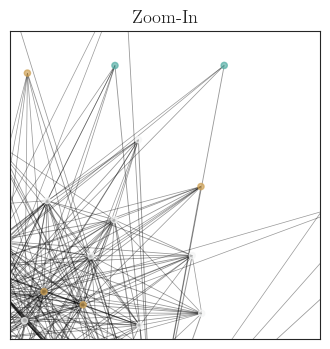

In [198]:
# plot
plt.figure(figsize=(4, 4))

nx.draw_networkx_nodes(G, pos, alpha=0.7, node_size=20, 
                       node_color=list(communities.values()), cmap=plt.colormaps.get_cmap('BrBG'))
nx.draw_networkx_edges(G, pos, alpha=0.4, edgelist=edges, width=[d['weight'] for (u, v, d) in edges])
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

plt.ylim(0.15, 0.65)
plt.xlim(-0.2, 0.3)

plt.title('Zoom-In')
plt.savefig("Plots/Supercontigs_Interactions_threshold_noannot_zoom.pdf", bbox_inches='tight')
plt.show()